In [15]:
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
import random
import gensim
import gensim.downloader as api

from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Machine learning with categorical data

## Logistic regression

Linear regression based machine learning methods are used to predict numerical outputs. That is, based on the paramteters estimated from its training data, the algorithm takes a series of inputs and predicts the estimated value of their output. However, whilst this method is very useful, there are many situations where we want to predict a *category* rather than a number. For example, we may wish to estimate whether the data predicts whether or not test is passed based on hours studied, or what species of animal is represented based on features in an image, or whether a customer is likely to make a purchase based on their browsing history. This is like regression modelling, except that the numbers in the data are used to predict a categorical rather than a numerical output.

Several machine learning algorithms exist for dealing with this situation. We're going to look at one of these––logistic regression––and explore how it can be used for predicting binary categories. This is when we have two outputs (pass or fail, cat or dog, sale or not-sale), with these outcomes represented as $0$ and $1$. It can also be adapted to deal with more than two categories, but we won't be looking at that case.

The logic of binary logistic regression works as follows. The model uses a function called the logit function to map the outputs of a regression into the range $(0,1)$. This is useful, because we can then interpret the results of the regression model as probabilities: if they are greater than $0.5$, the model predicts success; if they are less, the model predicts failure. In more detail, the logit function has the following form:

$$p(x) = \frac{1}{1+e^{-t}}$$

As you can see, the logit function compresses its output into the $0$ to $1$ range:

<AxesSubplot: >

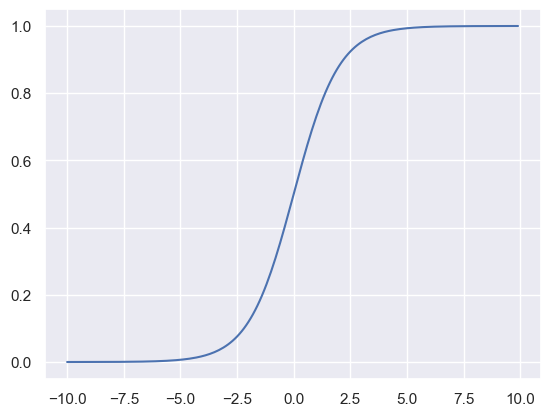

In [5]:
t = np.arange(-10, 10, 0.1)

def logit(x):
    y = 1/(1+np.exp(-x))
    return y

sns.lineplot(x = t, y = [logit(i) for i in t])

## Logistic regression and linear regression

The key to understanding logistic regression comes with interpreting the parameter $t$. In logistic regression with a predictor variable $x$ and a predicted variable $y$, this corresponds to the equation for linear regression:

$$y = \beta_{0} + \beta_{1}x$$

where $\beta_{0}$ is the $y$ intercept and $\beta_{1}$ is the slope of the line of best fit.

That is:

$$p(x) = \frac{1}{1+e^{-(\beta_{0} + \beta_{1}x)}}$$

But how should we interpret this? To understand what's happening, we need to know about *log odds*. The log odds of an event is simply the logarithm of probility of that event occurring divided by the probability of it not occurring. That is, the log odds of an event of proability $p$ is:

$$\ln{\frac{p}{1-p}}$$

Imagine that in a class of students, the probability of a student passing an exam after attending 90% of classes is 0.75. The log odds of a student passing is therefore:

$$\ln{\frac{0.75}{0.25}} = 1.09$$

If this number is large, there is a high probability of success; if it is small, there is a low probability of success.

For every value taken by the predictor variable $x$ (the percentage of classes attended) the log odds of a student passing can be calcualted. And because the log odds come in the form of a continuous number than a category, they can then be estimated using a standard linear regression model:

$$y =\ln{\frac{p(1)}{p(0)}} = \beta_{0} + \beta_{1}x$$

where $1$ represents passing the exam and $0$ represents failing. By estimating the $\beta_{0}$ and $\beta_{1}$ parameters and inserting them into the logit function, we can therefore 'squash' our regression outputs into the (0,1) range, and interpret the results as probabilities. When greater than 0.5, the event is classed as one category (1 = pass) and less than 0.5 it's classed as another (0 = fail). 

## Evaluating model performance on categorical data

With linear regression, the performance of the model is assessed using $R^2$, which gives the goodness of model fit. This doesn't work for categorical data, because the model outputs are categories rather than numbers. Four metrics are typically used to assess model performance in this case: *precision*, *recall*, *accuracy*, and the *F1 score*. These all take values between $0$ and $1$, where $1$ is a perfect score.

1. Precision: The precision score of a model measures how many of the positive predictions made by the model are in truth positive predictions. It's calculated as follows, where $TP$ means 'True Positive' and $FP$ means 'False Positive':

$$Precision = \frac{TP}{TP+FP}$$

2. Recall: The recall score of a model measures what fraction of the true positive cases the model manages to predict. It's calculated as follows, where $FN$ means 'False Negative':

$$Recall = \frac{TP}{TP+FN}$$

3. Accuracy: The accuracy score of model measures what fraction of correct predictions the model makes relative to the total number of predictions it makes. It's calculated as follows:

$$Accuracy = \frac{TN+TP}{TN+FP+TP+FN}$$

4. F1: The F1 score of a model is the harmonic mean of precision and recall. It's used because it gives a way of capturing both metrics in a single score. It's calculated as follows:

$$F1 = \frac{2TP}{2TP+FP+FN}$$

Which metric is chosen to evaluate the model depends on the purpose it's being used for. But in practice, the $F1$ is usually the best measure to use, as it gives a more rounded appreciation of model performance. 


## Logistic regression and NLP

There are lots of situations in NLP where logistic regression is useful. For instance, we might want to classify whether or not an email is spam based on the language used, or classify comments as being toxic or not. Here, we're going to build a profanity detector. That is, we will train a logistic regression classifier to evaluate whether or not a word is a profanity, with 'profanity' being understood to include terms of racial, sexual, religious, and other forms of abuse. We will do this in the following way:

1. Obtain a list of profanity words and non-profanity words and label them, where $1$ denotes a profanity and $0$ a non-profanity.
2. Get word embeddings for these words using a pre-trained model from Twitter.
3. Train a logistic regression model on a fraction of this dataset.
4. Evaluate our model's performance on a the retained test sample.
5. See how our model performs in the wild.

### 1. Getting our database of words

We will take our list of profanity words from the [Surge AI github repo](https://github.com/surge-ai/profanity). **Trigger Warning**: this list is comprehensive and you will find many offensive terms it. Do not read it if you are likely to find it upsetting. We will take our non-profanity words as a random sample from our VAD dataset. Because the Surge AI list has about 500 words and we want our training data to be balanced, the non-profanity sample will also be 500 words. 

In [6]:
prof = pd.read_csv('/Users/jamescarney/profanity/profanity_en.csv') #opens our list of profanity words

vad = pd.read_csv('/Users/jamescarney/Desktop/VAD_API/Warriner_rescale.csv', index_col = 0) #Loads our VAD data
vad = vad[['V.Mean.Sum', 'A.Mean.Sum', 'D.Mean.Sum']]
vad.columns = ['valence', 'arousal', 'dominance']good_words = [i for i in vad.index]



### 2. Load our pre-trained model

We will use a model pre-trained on Twitter to get our word embeddings. These embeddings are what are known as `GloVe` vectors; the are similar to `word2vec` vectors but are captured using a different algorithm. Once we've done this, we will pull out the word-embedding vectors for our profanity and non-profanity words and combine the results into a dataframe. We will create a `label` column in the dataframe that assigns $1$ to a profanity word and $0$ to a non-profanity word.

In [9]:
model = api.load("glove-twitter-200")

In [11]:
good_words = [i for i in vad.index]
good_words = random.sample(good_words, 500)

good_words_ = []
good_word_vectors = []

for i in good_words:
    try:
        good_word_vectors.append(model[i])
        good_words_.append(i)
    except:
        pass

bad_words = []
bad_word_vectors = []

for i in prof['text']:
    try:
        bad_word_vectors.append(model[i])
        bad_words.append(i)
    except:
        pass

In [12]:
profanity = pd.DataFrame()
profanity['words'] = bad_words
profanity['label'] = 1
bad_vecs = pd.DataFrame(bad_word_vectors)
profanity = pd.concat([profanity, bad_vecs], axis = 1)

not_prof = pd.DataFrame()
not_prof['words'] = good_words_
not_prof['label'] = 0
good_vecs = pd.DataFrame(good_word_vectors)
not_prof = pd.concat([not_prof, good_vecs], axis = 1)

data = pd.concat([profanity, not_prof]).reset_index(drop = True)

In [13]:
data

,words,label,0,1,2,3,4,5,6,7,...,190,191,192,193,194,195,196,197,198,199
0,abbie,1,-0.329500,0.085633,0.36949,-0.074677,-0.69475,0.044499,-0.083036,-0.017181,...,-0.527830,0.408630,0.105730,-0.430270,-0.483210,-0.709040,0.717630,-0.048857,0.187110,-0.464220
1,abeed,1,-0.485850,0.419280,-0.27153,-0.122530,-0.91392,-0.391950,-0.586190,0.554930,...,-0.017666,-0.365510,-0.099251,0.658930,-0.741040,0.261200,0.844530,0.066441,-0.326710,-0.799120
2,aboe,1,-0.239690,0.249420,-0.29688,-0.024667,-0.32035,-0.394760,-0.308500,-0.711500,...,0.406490,0.290960,-0.398580,-0.107710,0.218790,-0.137130,0.569850,0.024671,-0.981870,0.235720
3,anal,1,-0.776660,-0.323780,0.65202,-0.045757,-0.11865,-0.405230,0.466450,0.234970,...,0.204910,-0.720360,-0.489530,0.056852,1.146400,-0.106290,0.248590,0.141540,-0.739220,-0.070684
4,analingus,1,-0.650990,-0.783900,0.31116,-0.515960,-0.26272,-0.411900,0.414180,-0.218250,...,0.615030,-0.757560,0.659290,0.312920,-0.055653,-0.398210,0.028032,0.175700,-0.675020,-0.090851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,employment,0,0.396370,-0.175640,-0.67779,-0.296250,0.31742,0.054992,0.714460,-0.302520,...,0.647930,-0.811810,0.668000,-0.459320,-0.020810,-0.780850,0.197580,0.051412,0.287660,-0.707980
988,innocence,0,-0.028419,-0.163720,-0.34169,0.601560,0.32881,0.352210,0.371940,-0.601690,...,0.691960,0.090765,-0.539420,0.973210,0.743630,0.025837,0.029231,0.058157,-0.184260,-0.721350
989,platter,0,-0.309040,0.050861,0.12084,-0.193310,0.17790,0.374320,0.145030,0.021865,...,-0.080114,-0.013020,0.520150,0.132700,0.531500,-0.041028,0.932000,0.380190,0.274880,-0.074193
990,courteous,0,-0.004091,0.244950,0.33981,0.662490,0.39993,0.336050,0.104200,-0.536210,...,-0.416560,0.370360,0.162440,-0.357850,0.204060,-0.440760,0.383750,0.412020,-0.924990,-0.586510


### 3. Train a logistic regression classifier on our data

This procedure is more-or-less the same as the procedure for linear regression, where we withhold a fraction of the data for testing purposes. 

In [16]:
X = data.drop(['words', 'label'], axis = 'columns')
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train) #This fits the model to the training data

In [20]:
preds = clf.predict(X_test) # This outputs the model predictions on the withheld test data

### 4. Evaluate our model on the retained test data

We can evaluate the model on all of our four evaluation metrics if we like, but the `scikit-learn` `classification_report` function gives a useful summary of all four.

In [ ]:
print(classification_report(y_test, preds))

### 5. Test our model in the wild

Having trained our model, it should now be able to classify words in the pre-trained model that are not in the profanity list. It should also be able to distinguish between words that are merely *unpleasant* rather than offensive. (Note that the Twitter vocabulary has all been lowercased, so queried words should also be lowercased.)

In [69]:
test_cases = ['snot', 'scum', 'turd', 'piss', 'commie', 'nazi', 'bloody', 'peasant', 'bigot']

In [73]:
tests = []

for i in test_cases:
    tests.append(clf.predict(model[i.lower()].reshape(1, -1))[0])

